In [5]:
import pandas as pd

df = pd.read_parquet("../data/processed/reviews_clean.parquet")
print(df.shape)
print(df.sample(3)[["business_name", "rating", "text_clean"]])


(1100, 18)
     business_name  rating                                         text_clean
707       Ege Vera       5  portions are big. the flavors are nice. servic...
1028    Say Cheese       4  a delicious masterpiece comes out when it is m...
270     Bunbun Kas       5  i can say that cleanliness; taste; warm-bloode...


01 — Exploratory Data Analysis (Google Reviews)
- Uses processed file from `src/preprocess.py`
- Focus: distributions, text stats, suspicious patterns (URLs, ALLCAPS, short texts), author/business behaviour.

In [7]:
import os, math, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

pd.set_option("display.max_colwidth", 200)

DATA_PARQUET = "../data/processed/reviews_clean.parquet"


 0) Load

In [8]:
assert os.path.exists(DATA_PARQUET), f"Not found: {DATA_PARQUET}"
df = pd.read_parquet(DATA_PARQUET)
print(df.shape)
df.head(3)

(1100, 18)


,business_name,author_name,photo_path,has_photo,rating,category_raw,category_id,text_raw,text_clean,has_url,length_chars,length_tokens,num_exclaim,num_question,num_caps_tokens,is_short,timestamp,review_id
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,dataset/taste/hacinin_yeri_gulsum_akar.png,True,5,taste,3,We went to Marmaris with my wife for a holiday. We chose this restaurant as a place for dinner based on the reviews and because we wanted juicy food. When we first went there was a serious queue. ...,we went to marmaris with my wife for a holiday. we chose this restaurant as a place for dinner based on the reviews and because we wanted juicy food. when we first went there was a serious queue. ...,False,680,130,0,0,1,False,None,197806708066612212
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,dataset/menu/hacinin_yeri_oguzhan_cetin.png,True,4,menu,1,During my holiday in Marmaris we ate here to fit the food. It's really good that the food is cheap and nice. Eating as much bread as you want is a big plus for those who are not satisfied without ...,during my holiday in marmaris we ate here to fit the food. it's really good that the food is cheap and nice. eating as much bread as you want is a big plus for those who are not satisfied without ...,False,914,179,0,0,1,False,None,-5007835207484769476
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,dataset/outdoor_atmosphere/hacinin_yeri_yasin_kuyu.png,True,3,outdoor_atmosphere,2,Prices are very affordable. The menu in the photo cost 108 liras. You have to wait 10-15 minutes for food. Staff is annoying. Well it tastes good. Boiled meat was delicious.,prices are very affordable. the menu in the photo cost 108 liras. you have to wait 10-15 minutes for food. staff is annoying. well it tastes good. boiled meat was delicious.,False,173,31,0,0,0,False,None,-6239589702024109076


1) Basic structure & missing values

In [15]:
print(df.info())
print("\nMissing values:\n", df.isna().sum().sort_values(ascending=False))

# New provenance flags (fractions)
print("\nProvenance flags (%):")
for c in ["had_html","has_url","has_email","has_phone","contains_coupon",
          "is_empty_text_raw","is_empty_text_clean","is_rating_only","is_exact_dupe"]:
    if c in df.columns:
        v = (df[c].astype(float).mean()*100) if df[c].dtype != "Int64" else (df[c].fillna(0).astype(bool).mean()*100)
        print(f"  {c:22} {v:5.2f}%")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   business_name             1100 non-null   object        
 1   author_name               1100 non-null   object        
 2   photo_path                1100 non-null   object        
 3   has_photo                 1100 non-null   bool          
 4   rating                    1100 non-null   int64         
 5   category_raw              1100 non-null   object        
 6   category_id               1100 non-null   Int16         
 7   text_raw                  1100 non-null   object        
 8   text_stripped             1100 non-null   object        
 9   had_html                  1100 non-null   boolean       
 10  text_clean                1100 non-null   object        
 11  has_url                   1100 non-null   boolean       
 12  num_urls            

2) Duplicate check + quick preview

In [19]:
dupes = df.duplicated(subset=["business_name","author_name","text_clean"]).sum()
print("Exact dupes (business, author, text_clean):", dupes)

print("\nRandom sample:")
cols = [
    "business_name","author_name","rating","category_raw",
    "had_html","has_url","num_urls","has_email","has_phone","contains_coupon",
    "is_short","num_exclaim","num_question","num_caps_tokens",
    "is_empty_text_clean","is_rating_only","is_exact_dupe","dupe_count",
    "text_clean"
]
existing = [c for c in cols if c in df.columns]
display(df[existing].sample(min(5, len(df)), random_state=42))


Exact dupes (business, author, text_clean): 0

Random sample:


,business_name,author_name,rating,category_raw,had_html,has_url,num_urls,has_email,has_phone,contains_coupon,is_short,num_exclaim,num_question,num_caps_tokens,is_empty_text_clean,is_rating_only,is_exact_dupe,dupe_count,text_clean
328,Sardalye,Guney Gecer,4,taste,False,False,0,False,False,False,False,0,0,0,False,False,False,1,i went to there with my girl friend; i liked fishes but she did not like because fishes are a little bit oily.
688,Duveroglu,Can Akkaynak,4,menu,False,False,0,False,False,False,False,0,0,0,False,False,False,1,good in general. quality for kızılay and its surroundings. lahmacun doesn't taste old...
413,Pecko Firin Atakum,Burhan Arslan,5,taste,False,False,0,False,False,False,False,0,0,0,False,False,False,1,my first stop for breakfast in atakum is a place with quality service and friendly face.
788,Asucan Restaurant,Kjiong Son,3,indoor_atmosphere,False,False,0,False,False,False,True,0,0,0,False,False,False,1,place was not clear.
244,Tuana Restaurant,Ahmet Ekim,1,taste,False,False,0,False,False,False,False,1,0,4,False,False,False,1,definitely do not come. we came here for breakfast based on the reviews on the way. we said the breakfast called the village breakfast for 2 people. first of all; the employee greeted us disrespec...


3) Distributions - ratings and review lengths

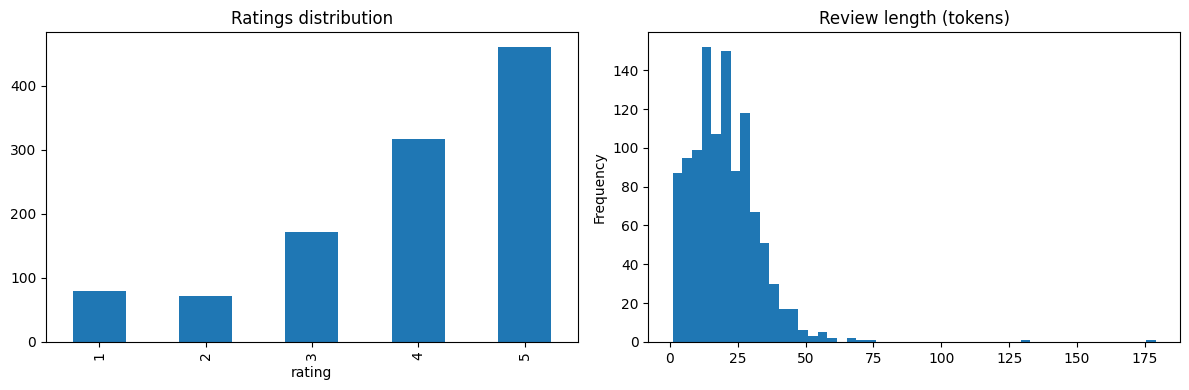

Mean tokens: 20.05
Median tokens: 19.0


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
df["rating"].dropna().astype(int).value_counts().sort_index().plot(kind="bar", ax=axes[0], title="Ratings distribution")
df["length_tokens"].plot(kind="hist", bins=50, ax=axes[1], title="Review length (tokens)")
plt.tight_layout()
plt.show()

print("Mean tokens:", df["length_tokens"].mean().round(2))
print("Median tokens:", df["length_tokens"].median())

4) Text signals linked to policies

In [20]:
print("Has URL (%):", round(df["has_url"].astype(float).mean()*100, 2))
if "num_urls" in df:
    print("Avg # URLs:", round(df["num_urls"].fillna(0).astype(float).mean(), 2))
print("Had HTML tags (%):", round(df["had_html"].astype(float).mean()*100, 2))
print("Has email (%):", round(df["has_email"].astype(float).mean()*100, 2))
print("Has phone (%):", round(df["has_phone"].astype(float).mean()*100, 2))
print("Contains coupon word (%):", round(df["contains_coupon"].astype(float).mean()*100, 2))

print("Short reviews (<=10 tokens) (%):", round(df["is_short"].astype(float).mean()*100, 2))
print("Avg exclamation marks:", df["num_exclaim"].mean().round(3))
print("Avg question marks:", df["num_question"].mean().round(3))
print("Avg ALLCAPS tokens:", df["num_caps_tokens"].mean().round(3))

# Heuristics from preprocessing (if present)
if "looks_promo_heur" in df:
    print("Looks promo-like (%):", round(df["looks_promo_heur"].astype(float).mean()*100, 2))
if "looks_rant_no_visit_heur" in df:
    print("Looks rant/no-visit (%):", round(df["looks_rant_no_visit_heur"].astype(float).mean()*100, 2))
if "looks_irrelevant_heur" in df:
    print("Looks irrelevant (%):", round(df["looks_irrelevant_heur"].astype(float).mean()*100, 2))


Has URL (%): 0.0
Avg # URLs: 0.0
Had HTML tags (%): 0.36
Has email (%): 0.0
Has phone (%): 0.0
Contains coupon word (%): 0.18
Short reviews (<=10 tokens) (%): 22.73
Avg exclamation marks: 0.085
Avg question marks: 0.006
Avg ALLCAPS tokens: 0.045
Looks promo-like (%): 0.18
Looks rant/no-visit (%): 0.0
Looks irrelevant (%): 0.09


- Peek examples for each signal

In [21]:
def show_examples(mask, n=5, columns=None, title=""):
    cols = columns or ["business_name","author_name","rating","text_raw","text_clean"]
    subset = df.loc[mask, cols].head(n)
    print(f"\n{title}  count={int(mask.sum())}\n")
    display(subset)

show_examples(df["has_url"].astype(bool), 5, title="Examples: has_url == True")
show_examples(df["is_short"].astype(bool), 5, title="Examples: is_short == True")
show_examples((df["num_caps_tokens"] >= 3), 5, title="Examples: many ALLCAPS tokens (>=3)")
show_examples((df["num_exclaim"] >= 3), 5, title="Examples: many exclamations (>=3)")

# New heuristic examples (if present)
if "looks_promo_heur" in df:
    show_examples(df["looks_promo_heur"].astype(bool), 5, title="Promo-like heuristic == True")
if "looks_rant_no_visit_heur" in df:
    show_examples(df["looks_rant_no_visit_heur"].astype(bool), 5, title="Rant/no-visit heuristic == True")
if "looks_irrelevant_heur" in df:
    show_examples(df["looks_irrelevant_heur"].astype(bool), 5, title="Irrelevant heuristic == True")



Examples: has_url == True  count=0



,business_name,author_name,rating,text_raw,text_clean



Examples: is_short == True  count=250



,business_name,author_name,rating,text_raw,text_clean
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,5,Turkey's cheapest artisan restaurant and its food is delicious!,turkey's cheapest artisan restaurant and its food is delicious!
5,Haci'nin Yeri - Yigit Lokantasi,Arda Karaca,4,Generally good.,generally good.
7,Haci'nin Yeri - Yigit Lokantasi,Nadia Salim,5,Delicious food at rock bottom prices. Friendly staff; Highly recommend,delicious food at rock bottom prices. friendly staff; highly recommend
9,Haci'nin Yeri - Yigit Lokantasi,Celal Ozer,5,The most f/p of all businesses I've seen.,the most f/p of all businesses i've seen.
25,Cafe Inn,Tugba Gunaydin,4,The vegan breakfast made me extremely happy. It was nice.,the vegan breakfast made me extremely happy. it was nice.



Examples: many ALLCAPS tokens (>=3)  count=1



,business_name,author_name,rating,text_raw,text_clean
244,Tuana Restaurant,Ahmet Ekim,1,DEFINITELY DO NOT COME. We came here for breakfast based on the reviews on the way. We said the breakfast called the village breakfast for 2 people. First of all; the employee greeted us disrespec...,definitely do not come. we came here for breakfast based on the reviews on the way. we said the breakfast called the village breakfast for 2 people. first of all; the employee greeted us disrespec...



Examples: many exclamations (>=3)  count=2



,business_name,author_name,rating,text_raw,text_clean
23,Cafe Inn,Hooman Sadati,1,Without any taste how they are at the first rank!!!! We ate cafe Inn pizza. It was 70 tl.,without any taste how they are at the first rank!!!! we ate cafe inn pizza. it was 70 tl.
589,Sanukiya,Arthur Jonathan,5,The queue was not that long fortunately! The staffs were all very kind and welcoming. The food was amazing! The udon was the hero; it was very flavorful & juicy!,the queue was not that long fortunately! the staffs were all very kind and welcoming. the food was amazing! the udon was the hero; it was very flavorful & juicy!



Promo-like heuristic == True  count=2



,business_name,author_name,rating,text_raw,text_clean
15,Pizza Fellas,Mustafa Caliskan,3,It's in a nice place but it's very small and their pizza is not that good to be exaggerated. Pizza dough is nice and thin. They do not offer advice to the customer.,it's in a nice place but it's very small and their pizza is not that good to be exaggerated. pizza dough is nice and thin. they do not offer advice to the customer.
212,Vefa Bozacisi,Ela Ensar,5,Boza's are beautiful. The ones on sale are also freshly filled and prepared. It looks clean; but I don't know the exact details.,boza's are beautiful. the ones on sale are also freshly filled and prepared. it looks clean; but i don't know the exact details.



Rant/no-visit heuristic == True  count=0



,business_name,author_name,rating,text_raw,text_clean



Irrelevant heuristic == True  count=1



,business_name,author_name,rating,text_raw,text_clean
204,Patso Burger,Burak Topal,3,Prices are not real; we thought it was a camera joke.,prices are not real; we thought it was a camera joke.


5) Business-level & author-level behaviour

In [14]:
biz_counts = df["business_name"].value_counts()
print("Businesses — top 10 by review count:")
display(biz_counts.head(10).to_frame("num_reviews"))

# proportion of URL reviews per business (suspicion)
biz_url_rate = df.groupby("business_name")["has_url"].mean().sort_values(ascending=False)
print("\nBusinesses with highest URL rate (top 10):")
display((biz_url_rate.head(10)*100).round(1).to_frame("%_has_url"))

# authors reviewing many different businesses (possible paid accounts)
auth_span = df.groupby("author_name")["business_name"].nunique().sort_values(ascending=False)
print("\nAuthors reviewing most unique businesses (top 10):")
display(auth_span.head(10).to_frame("unique_businesses"))

Businesses — top 10 by review count:


,num_reviews
business_name,
Haci'nin Yeri - Yigit Lokantasi,11
Rumeli Iskembecisi,11
Koco Restaurant,11
Ciya Sofrasi,11
Asucan Restaurant,11
Sema Gozleme,11
Umut Pide,11
Yesemek,11
Balikci Tanju,11



Businesses with highest URL rate (top 10):


,%_has_url
business_name,
Abidin Tantuni,0.0
Midpoint,0.0
Pecko Firin Atakum,0.0
Patso Burger,0.0
Nusr-et,0.0
Nesh,0.0
Nazar Cafe,0.0
My Friends Burger,0.0
Monica Kitchen,0.0



Authors reviewing most unique businesses (top 10):


,unique_businesses
author_name,
Nihat Karabiber,3
Mustafa Ay,3
Ece Oztunc,3
Saliha Senyildiz,3
Barkin Kizilkaya,2
Ediz Aksoy,2
Rifat Ozbek,2
Bilal Duzenli,2
Enes Ozturk,2


6) Token stats — top unigrams/bigrams
    - Helps spot promotional or irrelevant language.

In [15]:
def top_ngrams(texts, ngram_range=(1,1), top_k=30, stop_words="english"):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words, min_df=2)
    X = vec.fit_transform(texts)
    freqs = np.asarray(X.sum(axis=0)).ravel()
    terms = np.array(vec.get_feature_names_out())
    idx = np.argsort(freqs)[::-1][:top_k]
    return pd.DataFrame({"term": terms[idx], "freq": freqs[idx]})

top_uni = top_ngrams(df["text_clean"], (1,1), 30)
top_bi  = top_ngrams(df["text_clean"], (2,2), 30)
print("Top unigrams:")
display(top_uni)
print("\nTop bigrams:")
display(top_bi)

Top unigrams:


,term,freq
0,good,287
1,place,251
2,delicious,207
3,nice,172
4,taste,170
5,service,155
6,food,146
7,prices,126
8,great,81
9,recommend,79



Top bigrams:


,term,freq
0,service fast,27
1,prices reasonable,24
2,ice cream,21
3,place nice,17
4,prices high,16
5,nice place,16
6,taste good,16
7,food delicious,16
8,prices little,14
9,didn like,14


In [22]:
if "is_exact_dupe" in df and "dupe_count" in df:
    total_dupes = int(df["is_exact_dupe"].sum())
    print(f"Exact duplicates (rows marked is_exact_dupe): {total_dupes}")
    if total_dupes > 0:
        display(df.loc[df["is_exact_dupe"], ["business_name","author_name","dupe_count","text_clean"]].head(10))


Exact duplicates (rows marked is_exact_dupe): 0


7) By rating buckets
    - Compare words used in low vs high ratings.

In [18]:
low  = df.loc[df["rating"] <= 2, "text_clean"]
high = df.loc[df["rating"] >= 4, "text_clean"]

print("Low-rating unigrams:")
display(top_ngrams(low, (1,1), 20))
print("\nHigh-rating unigrams:")
display(top_ngrams(high, (1,1), 20))

Low-rating unigrams:


,term,freq
0,service,29
1,bad,28
2,taste,27
3,place,23
4,food,22
5,good,20
6,waiters,16
7,like,15
8,didn,15
9,came,14



High-rating unigrams:


,term,freq
0,good,219
1,place,179
2,delicious,176
3,nice,139
4,taste,113
5,service,104
6,food,99
7,prices,93
8,great,76
9,recommend,68


8) Correlations among numeric features

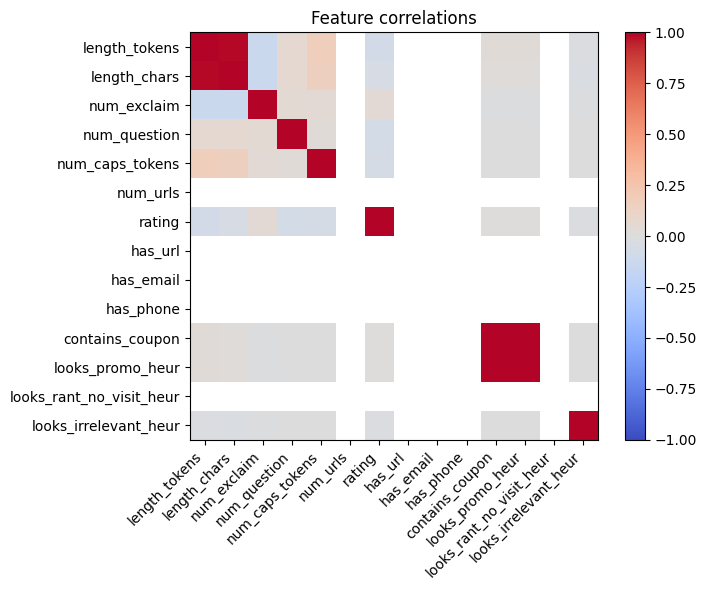

,length_tokens,length_chars,num_exclaim,num_question,num_caps_tokens,num_urls,rating,has_url,has_email,has_phone,contains_coupon,looks_promo_heur,looks_rant_no_visit_heur,looks_irrelevant_heur
length_tokens,1.00,0.99,-0.13,0.06,0.17,NaN,-0.08,NaN,NaN,NaN,0.03,0.03,NaN,-0.02
length_chars,0.99,1.00,-0.13,0.06,0.16,NaN,-0.05,NaN,NaN,NaN,0.02,0.02,NaN,-0.03
num_exclaim,-0.13,-0.13,1.00,0.05,0.04,NaN,0.05,NaN,NaN,NaN,-0.01,-0.01,NaN,-0.01
num_question,0.06,0.06,0.05,1.00,0.03,NaN,-0.07,NaN,NaN,NaN,-0.00,-0.00,NaN,-0.00
num_caps_tokens,0.17,0.16,0.04,0.03,1.00,NaN,-0.06,NaN,NaN,NaN,-0.01,-0.01,NaN,-0.01
num_urls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,-0.08,-0.05,0.05,-0.07,-0.06,NaN,1.00,NaN,NaN,NaN,0.00,0.00,NaN,-0.02
has_url,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_email,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_phone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
num_cols = [
    "length_tokens","length_chars","num_exclaim","num_question","num_caps_tokens",
    "num_urls","rating",
    "has_url","has_email","has_phone","contains_coupon"
]
for extra in ["looks_promo_heur","looks_rant_no_visit_heur","looks_irrelevant_heur"]:
    if extra in df.columns: num_cols.append(extra)

corr = df[num_cols].astype(float).corr()
plt.figure(figsize=(7.5,6))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Feature correlations")
plt.tight_layout()
plt.show()
corr.round(2)


9) Quick TF-IDF keywords per class (optional utility)
    - Show words strongly associated with "has_url" reviews (proxy for ads).

In [24]:
def class_tfidf_top_terms(texts, labels, top_k=20, label_name="pos"):
    vec = TfidfVectorizer(stop_words="english", min_df=2)
    X = vec.fit_transform(texts)
    vocab = np.array(vec.get_feature_names_out())
    mask1 = labels.astype(bool).values
    X1, X0 = X[mask1], X[~mask1]
    m1 = np.asarray(X1.mean(axis=0)).ravel()
    m0 = np.asarray(X0.mean(axis=0)).ravel()
    lift = (m1 + 1e-9) / (m0 + 1e-9)
    idx = np.argsort(lift)[::-1][:top_k]
    return pd.DataFrame({"term": vocab[idx], f"lift_{label_name}": lift[idx].round(3)})

if df["has_url"].sum() > 0:
    print("Terms over-indexed in has_url==True:")
    display(class_tfidf_top_terms(df["text_clean"], df["has_url"], 25, "has_url"))

if "looks_promo_heur" in df and df["looks_promo_heur"].sum() > 0:
    print("\nTerms over-indexed in looks_promo_heur==True:")
    display(class_tfidf_top_terms(df["text_clean"], df["looks_promo_heur"], 25, "promo"))



Terms over-indexed in looks_promo_heur==True:


,term,lift_promo
0,filled,791.162
1,exact,307.389
2,looks,186.522
3,boza,161.662
4,exaggerated,127.326
5,prepared,85.025
6,know,67.895
7,ones,51.318
8,customer,48.063
9,dough,35.201


10) Save quick summary report (CSV)

In [25]:
summary = {
    "n_reviews": len(df),
    "n_businesses": df["business_name"].nunique(),
    "has_url_pct": round(df["has_url"].astype(float).mean()*100, 2),
    "avg_num_urls": round(df.get("num_urls", pd.Series(0)).fillna(0).astype(float).mean(), 2),
    "had_html_pct": round(df["had_html"].astype(float).mean()*100, 2),
    "has_email_pct": round(df["has_email"].astype(float).mean()*100, 2),
    "has_phone_pct": round(df["has_phone"].astype(float).mean()*100, 2),
    "coupon_word_pct": round(df["contains_coupon"].astype(float).mean()*100, 2),
    "short_pct": round(df["is_short"].astype(float).mean()*100, 2),
    "avg_tokens": round(df["length_tokens"].mean(), 2),
    "avg_exclaim": round(df["num_exclaim"].mean(), 3),
    "avg_caps_tokens": round(df["num_caps_tokens"].mean(), 3),
    "rating_only_pct": round(df["is_rating_only"].astype(float).mean()*100, 2),
    "exact_dupe_rows": int(df.get("is_exact_dupe", pd.Series(False)).sum()),
}
for h in ["looks_promo_heur","looks_rant_no_visit_heur","looks_irrelevant_heur"]:
    if h in df.columns:
        summary[f"{h}_pct"] = round(df[h].astype(float).mean()*100, 2)

report_df = pd.DataFrame([summary])
os.makedirs("../reports", exist_ok=True)
report_df.to_csv("../reports/eda_summary.csv", index=False)
report_df


,n_reviews,n_businesses,has_url_pct,avg_num_urls,had_html_pct,has_email_pct,has_phone_pct,coupon_word_pct,short_pct,avg_tokens,avg_exclaim,avg_caps_tokens,rating_only_pct,exact_dupe_rows,looks_promo_heur_pct,looks_rant_no_visit_heur_pct,looks_irrelevant_heur_pct
0,1100,100,0.0,0.0,0.36,0.0,0.0,0.18,22.73,20.05,0.085,0.045,0.0,0,0.18,0.0,0.09
